In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
import networkx as nx
import importlib
from graphviz import Digraph, Source
from pygraphviz import AGraph
import numpy as np
import matplotlib.image as mpimg
from IPython.display import Image
import matplotlib.pyplot as plt
from flow import Node, CreditFlow, Graph, get_source_nodes, topo_sort, flatten_graph, eval_graph, boundary_graph, single_source_graph, viz_graph, save_graph
import copy
from flow import ParallelCreditFlow

In [3]:
def build_random_graph(n_nodes=10):
    nodes = []
    name = 'a'
    for _ in range(n_nodes):
        args = [nodes[i] for i in range(0 if len(nodes) == 0 else np.random.choice(len(nodes)))]
        node = Node(name, lambda *args: (sum(args) >= len(args)).astype(int), args) # and function
        # node = Node(name, lambda *args: int(sum(args) >= 1), args) # or function
        name = chr(ord(name) + 1)
        nodes.append(node)

    print(len(nodes), "nodes")
    source_nodes = get_source_nodes(nodes)
    n_relevant_features = np.random.choice(range(1, len(nodes)))
    feature_mask = np.random.choice(range(1, len(nodes)), n_relevant_features, replace=False)
    args = nodes
    target_node = Node('Y', lambda *args: sum([arg for i, arg in enumerate(args) if i in feature_mask]), 
                       args, is_target_node=True)
    nodes.append(target_node)
    
    graph = Graph(nodes,
                  dict((node.name, lambda: 0) for node in source_nodes),
                  dict((node.name, lambda: 1) for node in source_nodes),
                  )
    return graph

graph = build_random_graph()

10 nodes


bruteforce sampling: 100%|██████████| 100/100 [00:00<00:00, 359.01it/s]


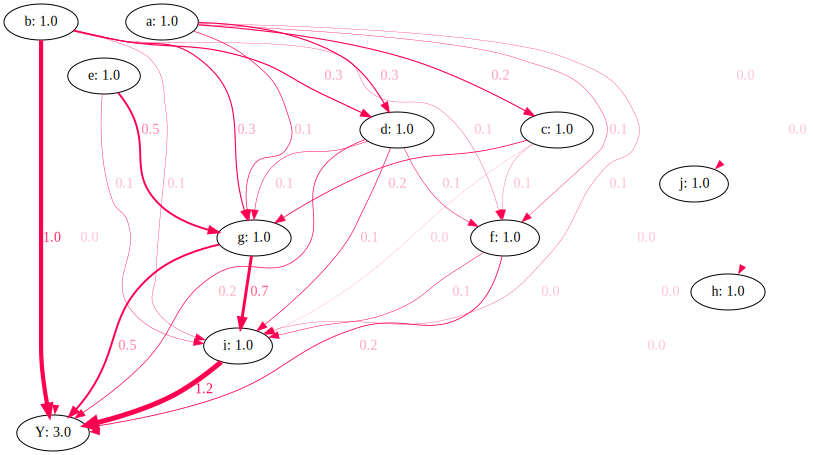

In [4]:
verbose = False
cf = CreditFlow(graph, verbose=verbose, nruns=100, visualize=verbose)
cf.run()

cf.draw(format_str="{:.1f}")

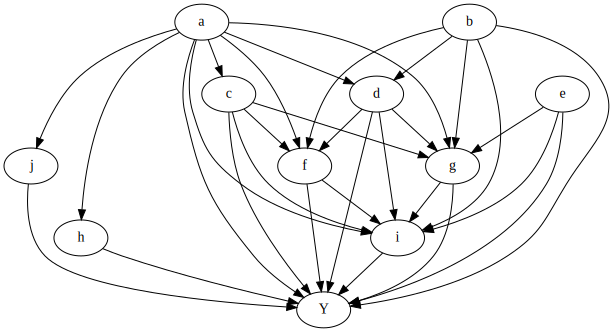

In [5]:
graph.draw()

bruteforce sampling: 100%|██████████| 100/100 [00:00<00:00, 880.51it/s]


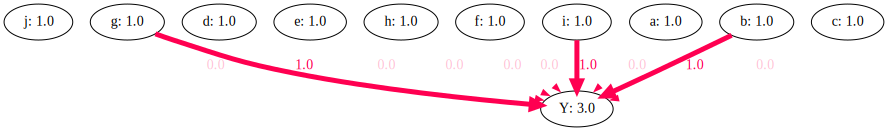

In [6]:
shap_graph = flatten_graph(graph)
verbose = False
cf = CreditFlow(shap_graph, verbose=verbose, nruns=100, visualize=verbose)
cf.run()

cf.draw(format_str="{:.1f}")

bruteforce sampling: 100%|██████████| 100/100 [00:00<00:00, 247.35it/s]


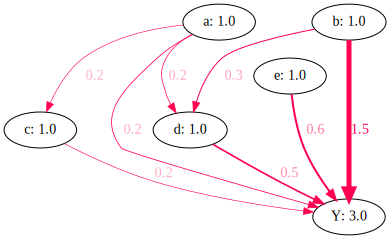

In [7]:
bgraph = boundary_graph(graph, ['a', 'b', 'c', 'd'])
verbose = False
cf = CreditFlow(bgraph, verbose=verbose, nruns=100, visualize=verbose)
cf.run()

cf.draw(format_str="{:.1f}")

Above we show explanation of a random system.

The first is Shapley flow, the second is Shap, and the third is some arbitrary boundary.

bruteforce sampling: 100%|██████████| 100/100 [00:00<00:00, 302.62it/s]


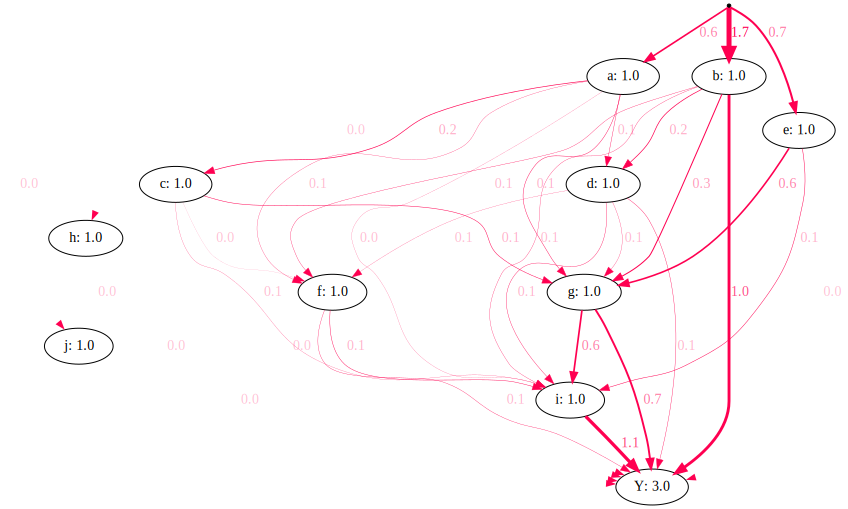

In [8]:
sgraph = single_source_graph(graph)
verbose = False
cf = CreditFlow(sgraph, verbose=verbose, nruns=100, visualize=verbose)
cf.run()

cf.draw(format_str="{:.1f}")

# Intervention simulation

In [9]:
sources = get_source_nodes(graph)
d = dict((node.name, 0) for node in sources)
d.update({'d': 1})
print('output:', eval_graph(graph, d))

output: [0]


# Parallel runs

In [10]:
nruns = 3000

In [11]:
cf = CreditFlow(graph, nruns=nruns)
%time cf.run()

bruteforce sampling: 100%|██████████| 3000/3000 [00:10<00:00, 281.45it/s]

CPU times: user 10.9 s, sys: 2.75 s, total: 13.7 s
Wall time: 10.7 s


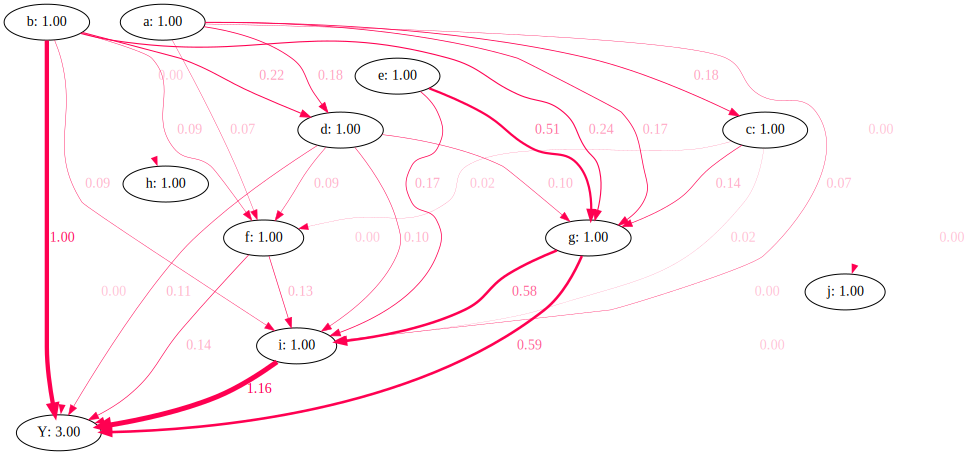

In [12]:
cf.draw()

In [16]:
cf = ParallelCreditFlow(graph, nruns=nruns, njobs=8)
%time cf.run_subprocess()

3000 runs with 8 jobs
wait [True, True, True, True, True, True, True, True]...
wait [True, True, True, True, True, True, True, True]...
wait [True, True, True, True, True, True, True, True]...
wait [True, True, True, True, True, True, True, True]...
wait [True, True, True, True, True, True, True, True]...
done
CPU times: user 13.3 ms, sys: 23.1 ms, total: 36.4 ms
Wall time: 5.06 s


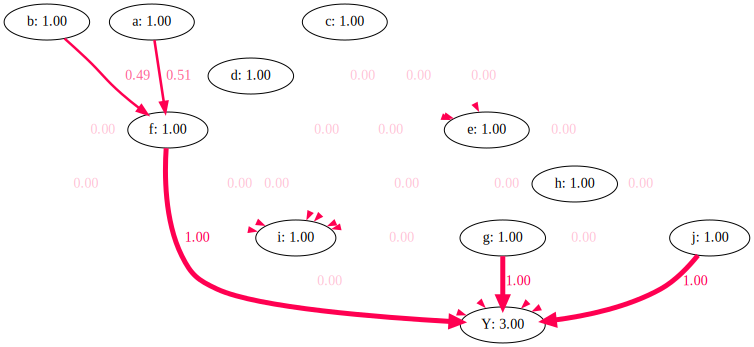

In [17]:
cf.draw()

In [18]:
cf = ParallelCreditFlow(graph, nruns=nruns, njobs=8)
%time cf.run_dill()

3000 runs with 8 jobs
CPU times: user 24.9 ms, sys: 79.6 ms, total: 105 ms
Wall time: 3.18 s


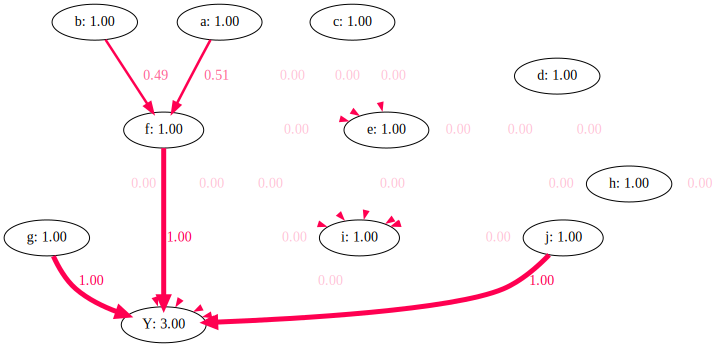

In [19]:
cf.draw()

In [20]:
cf = ParallelCreditFlow(graph, nruns=nruns, njobs=8)
%time cf.run_synthetic_process(method='mpd')

3000 runs with 8 jobs


sampling: 100%|██████████| 375/375 [00:01<00:00, 252.47it/s]


CPU times: user 230 ms, sys: 80.2 ms, total: 310 ms
Wall time: 1.66 s


In [21]:
cf = ParallelCreditFlow(graph, nruns=nruns, njobs=8)
%time cf.run_thread()

3000 runs with 8 jobs
CPU times: user 8.55 s, sys: 3.81 s, total: 12.4 s
Wall time: 8.37 s


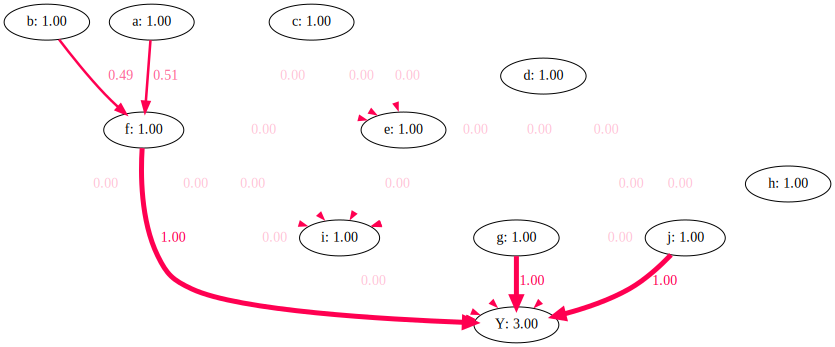

In [22]:
cf.draw()